In [3]:
import pandas as pd
import numpy as np
import stats
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils import get_occ_dfs, get_hmmconf_df, get_bp_df
import validation
from validation import get_dataset_metrics, extract_filename, plot_bar_chart_comparison, get_statistics, print_stat, print_procentual

from IPython.utils import io

In [4]:
INPUT_DIR = os.path.join('..','output')
PREFIX_ALIGN_DIR = os.path.join(INPUT_DIR, 'prefix-alignment')
PREFIX_W_1_DIR = os.path.join(PREFIX_ALIGN_DIR, 'window-size-1')
PREFIX_W_INF_DIR = os.path.join(PREFIX_ALIGN_DIR, 'window-size-maximum')
HMMCONF_DIR = os.path.join(INPUT_DIR,'hmmconf')
C_3PO_DIR = os.path.join(INPUT_DIR,'C-3PO','test')
BP_DIR = os.path.join(INPUT_DIR,'bp')

#LOGS = ["BPI_2012","BPI_2017","M1","M2","M4","M8","M9"]
NOT_BP_LOGS = ['M4','M9']
LOGS = ["BPI_2017","BPI_2012","M1","M2","M8"]
LOG_TYPES = ['completenes20', 'completeness50', 'sim']
COMPLETENESS_LOGS = ["completenes20","completeness50"]

In [5]:
#!jt -t grade3
#!jt -t chesterish
#jupyter nbconvert --to webpdf --no-input .\comparative_analysis.ipynb

## Datasets
note: Kristo can share his insights
- completeness logs
- regular logs
- model types

Additional:
1. Summary statistics
    - trace length distribution
    - unique acitivities
2. Behaviour (parallelism, XOR etc)

### Log statistics

## Preprocessing

In [6]:
from IPython.utils import io

occ_output_dirs = [C_3PO_DIR, PREFIX_W_1_DIR, PREFIX_W_INF_DIR, HMMCONF_DIR, BP_DIR]
with io.capture_output() as captured:
    C_3PO_df = get_occ_dfs(occ_output_dirs[0], True)

    pref_w_1_df = get_occ_dfs(occ_output_dirs[1])

    pref_w_inf_df = get_occ_dfs(occ_output_dirs[2])

    hmmconf_df = get_hmmconf_df(occ_output_dirs[3])

    BP_df = get_bp_df(occ_output_dirs[4])

In [7]:
print("3PO")
print(C_3PO_df.info())
print(80*"_")

3PO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TraceId            10500 non-null  int64  
 1   Conformance cost   10500 non-null  float64
 2   Completeness cost  10500 non-null  float64
 3   Confidence cost    10500 non-null  float64
 4   ExecutionTime      10500 non-null  float64
 5   model              10500 non-null  object 
 6   log_type           10500 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 574.3+ KB
None
________________________________________________________________________________


In [8]:
print("W-1")
print(pref_w_1_df.info())
print(80*"_")

W-1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TraceId           10500 non-null  int64  
 1   Conformance cost  10500 non-null  float64
 2   ExecutionTime     10500 non-null  float64
 3   model             10500 non-null  object 
 4   log_type          10500 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 410.3+ KB
None
________________________________________________________________________________


In [9]:
print("W-inf")
print(pref_w_inf_df.info())
print(80*"_")

W-inf
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TraceId           10500 non-null  int64  
 1   Conformance cost  10500 non-null  float64
 2   ExecutionTime     10500 non-null  float64
 3   model             10500 non-null  object 
 4   log_type          10500 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 410.3+ KB
None
________________________________________________________________________________


In [10]:
print("hmmconf")
print(hmmconf_df.info())
print("Traces total: {}".format(hmmconf_df.groupby(['model','log_type','TraceId']).agg({'ExecutionTime': np.sum}).shape[0]))
print(80*"_")

hmmconf
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41368 entries, 0 to 41367
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TraceId            41368 non-null  float64
 1   ExecutionTime      41368 non-null  float64
 2   emitconf           41368 non-null  float64
 3   stateconf          41368 non-null  float64
 4   finalconf          41368 non-null  float64
 5   injected_distance  41368 non-null  float64
 6   completeness       41368 non-null  float64
 7   model              41368 non-null  object 
 8   log_type           41368 non-null  object 
dtypes: float64(7), object(2)
memory usage: 2.8+ MB
None
Traces total: 2010
________________________________________________________________________________


In [11]:
print("BP")
print(BP_df.info())
print("Traces total: {}".format(BP_df.groupby(['model','log_type','TraceId']).agg({'ExecutionTime': np.sum}).shape[0]))
print(80*"_")

BP
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206418 entries, 0 to 206417
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TraceId        206418 non-null  int32  
 1   activityId     206418 non-null  object 
 2   conformance    206418 non-null  float64
 3   completeness   206418 non-null  float64
 4   confidence     206418 non-null  float64
 5   ExecutionTime  206418 non-null  float64
 6   model          206418 non-null  object 
 7   log_type       206418 non-null  object 
dtypes: float64(4), int32(1), object(3)
memory usage: 11.8+ MB
None
Traces total: 10500
________________________________________________________________________________


In [12]:
print("C_3PO_df")
print(C_3PO_df[['Completeness cost', 'Conformance cost', 'Confidence cost', 'ExecutionTime']].describe())
print(80*"_")

C_3PO_df
       Completeness cost  Conformance cost  Confidence cost  ExecutionTime
count       10500.000000      10500.000000     10500.000000   10500.000000
mean            1.051524         17.267524         2.827524       1.985524
std             1.830911         13.703859         5.206075       2.633461
min             0.000000          0.000000         0.000000       0.000000
25%             0.000000          6.000000         0.000000       1.000000
50%             0.000000         15.000000         0.000000       2.000000
75%             2.000000         25.000000         4.000000       3.000000
max            19.000000        170.000000        22.000000      80.000000
________________________________________________________________________________


In [13]:
print("pref_w_1_df")
print(pref_w_1_df[['Conformance cost', 'ExecutionTime']].describe())
print(80*"_")

pref_w_1_df
       Conformance cost  ExecutionTime
count      10500.000000   10500.000000
mean          17.537048      20.518133
std           12.339433      52.157159
min            0.000000       0.000000
25%            8.000000       1.000000
50%           15.000000       8.200000
75%           24.000000      21.850000
max          167.000000    1833.200000
________________________________________________________________________________


In [14]:
print("pref_w_inf_df")
print(pref_w_inf_df[['Conformance cost', 'ExecutionTime']].describe())
print(80*"_")

pref_w_inf_df
       Conformance cost  ExecutionTime
count      10500.000000   10500.000000
mean          15.201714      38.727562
std           11.512152     104.886534
min            0.000000       0.000000
25%            7.000000       3.400000
50%           12.000000      14.000000
75%           21.000000      40.200000
max          162.000000    4249.000000
________________________________________________________________________________


In [15]:
print("hmmconf")
print(hmmconf_df[['ExecutionTime', 'finalconf', 'injected_distance', 'completeness']].describe())
print(80*"_")

hmmconf
       ExecutionTime     finalconf  injected_distance  completeness
count   41368.000000  41368.000000       41368.000000  41368.000000
mean        0.198358      0.443630           7.141269      0.699586
std         0.777391      0.417259           7.716626      0.227686
min         0.000000      0.000000           0.000000      0.125000
25%         0.000000      0.081997           2.000000      0.545455
50%         0.000000      0.183405           5.000000      0.750000
75%         0.000000      0.984876           9.600000      0.876774
max        42.486520      1.000000          81.000000      1.000000
________________________________________________________________________________


In [16]:
print("BP_df")
print(BP_df[['ExecutionTime', 'conformance', 'completeness', 'confidence']].describe())
print(80*"_")

BP_df
       ExecutionTime    conformance   completeness     confidence
count  206418.000000  206418.000000  206418.000000  206418.000000
mean        0.001917       0.374243       0.693455       0.657628
std         0.034577       0.178135       0.287139       0.235074
min         0.000220       0.000000       0.000000       0.000000
25%         0.000900       0.250000       0.476190       0.520000
50%         0.001140       0.361667       0.771429       0.680000
75%         0.001480       0.487968       1.000000       0.840000
max         6.432220       1.000000       1.000000       1.000000
________________________________________________________________________________


## Validation

In [17]:
dims_14 = {'conf': 1, 'time': 2}
avg_costs_14 = {'conf': [], 'time': []}

dims_25 = {'conf': 1, 'compl': 2, 'confi': 3, 'total': 4, 'time': 5}
avg_costs_25 = {'conf': [], 'compl': [], 'confi': [], 'total': [], 'time': []}

no_compl_no_conf_dict, _ = get_dataset_metrics(
    INPUT_DIR+"/tripleocc_runs/no_compl_no_conf", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)
# no_compl_avg_dict, _ = get_dataset_metrics(
#     INPUT_DIR+"/tripleocc_runs/no_compl_avg", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)
# no_compl_min_dict, _ = get_dataset_metrics(
#     INPUT_DIR+"/tripleocc_runs/no_compl_min", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)
no_conf_ws_all_states_dict, _ = get_dataset_metrics(
    INPUT_DIR+"/tripleocc_runs/no_conf_ws_all_states", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)
no_conf_ws_root_dict, dataset_keys = get_dataset_metrics(
    INPUT_DIR+"/tripleocc_runs/no_conf_ws_root", dims=dims_25, avg_costs=avg_costs_25, regex_f=extract_filename)

### Completeness

In [18]:
no_compl_no_conf_compl_stats=get_statistics(no_compl_no_conf_dict, validation.completeness_output)
no_conf_ws_root_stats=get_statistics(no_conf_ws_root_dict, validation.completeness_output)
no_conf_ws_all_stats=get_statistics(no_conf_ws_all_states_dict, validation.completeness_output)

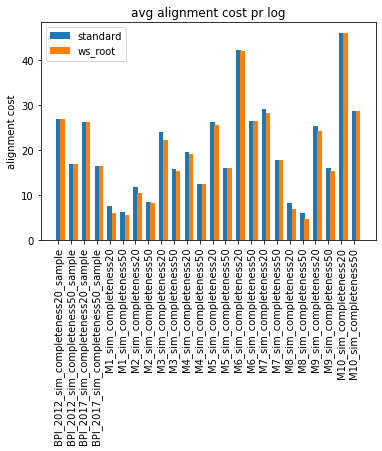

ws root stats:
ws root: mean mean all logs 19.437 - IWS: mean mean all logs 19.96
ws root: mean std all logs 9.896 - IWS: mean std all logs 9.679
Decrease % in conformance: -2.62


In [19]:
"""Grouped bar chart - ws root"""

plot_bar_chart_comparison(validation.completeness_output, no_compl_no_conf_compl_stats,
                            no_conf_ws_root_stats, 'mean', ['standard', 'ws_root'], "alignment cost", "avg alignment cost pr log")

print("ws root stats:")
print_stat('mean', no_conf_ws_root_stats, no_compl_no_conf_compl_stats, "ws root", "IWS")
print_stat('std', no_conf_ws_root_stats, no_compl_no_conf_compl_stats,  "ws root", "IWS")
print_procentual('mean','conformance',no_conf_ws_root_stats, no_compl_no_conf_compl_stats)

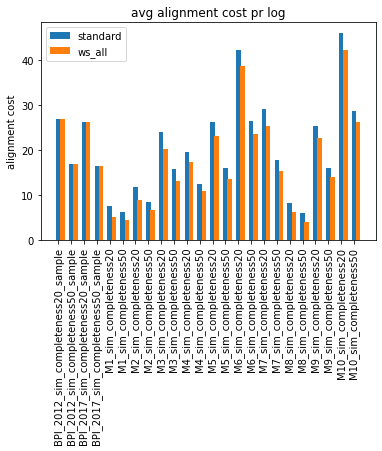

ws all stats:
ws all: mean mean all logs 17.804 - IWS: mean mean all logs 19.96
ws all: mean std all logs 9.402 - IWS: mean std all logs 9.679
Decrease % in conformance: -10.802


In [20]:
"""Grouped bar chart - ws all"""

plot_bar_chart_comparison(validation.completeness_output, no_compl_no_conf_compl_stats,
                            no_conf_ws_all_stats, 'mean', ['standard', 'ws_all'], "alignment cost", "avg alignment cost pr log")

print("ws all stats:")
print_stat('mean', no_conf_ws_all_stats, no_compl_no_conf_compl_stats, "ws all", "IWS")
print_stat('std', no_conf_ws_all_stats, no_compl_no_conf_compl_stats,  "ws all", "IWS")
print_procentual('mean','conformance',no_conf_ws_all_stats, no_compl_no_conf_compl_stats)

#### Completeness all logs

In [21]:
no_compl_no_conf_compl_stats = get_statistics(no_compl_no_conf_dict, validation.normal_output)
no_conf_ws_root_stats = get_statistics(no_conf_ws_root_dict, validation.normal_output)
no_conf_ws_all_stats = get_statistics(no_conf_ws_all_states_dict, validation.normal_output)

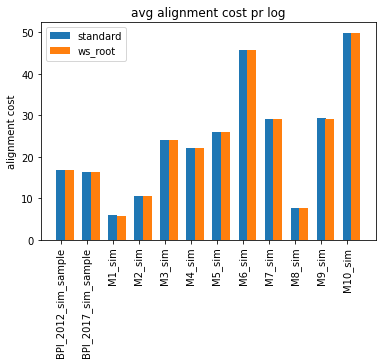

ws root stats:
avg conf: mean mean all logs 23.59 - IWS: mean mean all logs 23.623
avg conf: mean std all logs 14.317 - IWS: mean std all logs 14.316
Decrease % in conformance: -0.14


In [22]:
""" grouped bar chart ws root """

plot_bar_chart_comparison(validation.normal_output, no_compl_no_conf_compl_stats,
                          no_conf_ws_root_stats, 'mean', ['standard', 'ws_root'], "alignment cost", "avg alignment cost pr log")

print("ws root stats:")
print_stat('mean', no_conf_ws_root_stats, no_compl_no_conf_compl_stats, "avg conf", "IWS")
print_stat('std', no_conf_ws_root_stats, no_compl_no_conf_compl_stats,  "avg conf", "IWS")
print_procentual('mean','conformance',no_conf_ws_root_stats, no_compl_no_conf_compl_stats)

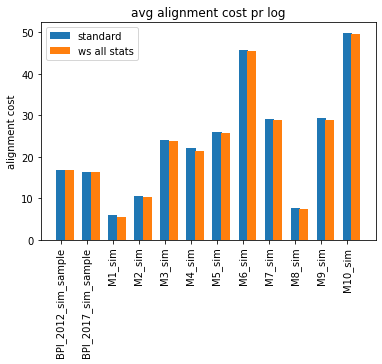

ws all stats:
avg conf: mean mean all logs 23.36 - IWS: mean mean all logs 23.623
avg conf: mean std all logs 14.269 - IWS: mean std all logs 14.316
Decrease % in conformance: -1.113


In [23]:
""" grouped bar chart ws all """

plot_bar_chart_comparison(validation.normal_output, no_compl_no_conf_compl_stats,
                          no_conf_ws_all_stats, 'mean', ['standard', 'ws all stats'], "alignment cost", "avg alignment cost pr log")

print("ws all stats:")
print_stat('mean', no_conf_ws_all_stats, no_compl_no_conf_compl_stats, "avg conf", "IWS")
print_stat('std', no_conf_ws_all_stats, no_compl_no_conf_compl_stats,  "avg conf", "IWS")
print_procentual('mean','conformance',no_conf_ws_all_stats, no_compl_no_conf_compl_stats)

##### Mean execution time comparison

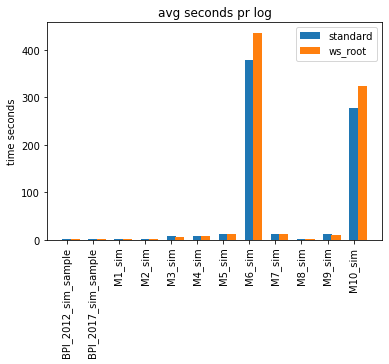

Increase % in time: 14.429


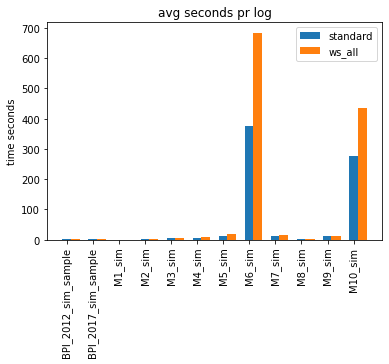

Increase % in time: 67.402


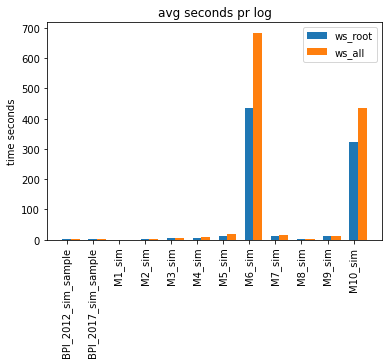

Increase % in time: 46.294


In [24]:
plot_bar_chart_comparison(validation.normal_output, no_compl_no_conf_compl_stats,
                          no_conf_ws_root_stats, 'time', ['standard', 'ws_root'], "time seconds", "avg seconds pr log")

print_procentual('time','time',no_conf_ws_root_stats, no_compl_no_conf_compl_stats)

plot_bar_chart_comparison(validation.normal_output, no_compl_no_conf_compl_stats,
                          no_conf_ws_all_stats, 'time', ['standard', 'ws_all'], "time seconds", "avg seconds pr log")

print_procentual('time','time',no_conf_ws_all_stats, no_compl_no_conf_compl_stats)

plot_bar_chart_comparison(validation.normal_output, no_conf_ws_root_stats,
                          no_conf_ws_all_stats, 'time', ['ws_root', 'ws_all'], "time seconds", "avg seconds pr log")

print_procentual('time','time',no_conf_ws_all_stats, no_conf_ws_root_stats)

### Confidence

In [25]:
# no_compl_no_conf_conf_stats = get_statistics(no_compl_no_conf_dict, validation.confidence_output)
# no_compl_avg_conf_stats = get_statistics(no_compl_avg_dict, validation.confidence_output)
# no_compl_min_conf_stats = get_statistics(no_compl_min_dict, validation.confidence_output)

In [26]:
# """Grouped bar chart - confidence average"""

# plot_bar_chart_comparison(validation.confidence_output, no_compl_no_conf_conf_stats,
#                           no_compl_avg_conf_stats, 'mean', ['standard', 'avg'], "alignment cost", "avg alignment cost pr log")

# print("no completeness avg conf stats:")
# print_stat('mean', no_compl_avg_conf_stats, no_compl_no_conf_conf_stats, "avg conf", "IWS")
# print_stat('std', no_compl_avg_conf_stats, no_compl_no_conf_conf_stats,  "avg conf", "IWS")
# print_procentual('mean','conformance',no_compl_avg_conf_stats, no_compl_no_conf_conf_stats)


In [27]:
# plot_bar_chart_comparison(validation.confidence_output, no_compl_no_conf_conf_stats,
#                           no_compl_min_conf_stats, 'mean', ['standard', 'min'], "alignment cost", "avg alignment cost pr log")

# print("no completeness min conf stats:")
# print_stat('mean', no_compl_min_conf_stats, no_compl_no_conf_conf_stats, "min conf", "IWS")
# print_stat('std', no_compl_min_conf_stats, no_compl_no_conf_conf_stats,  "min conf", "IWS")
# print_procentual('mean','conformance',no_compl_min_conf_stats, no_compl_no_conf_conf_stats)

## Stress test

- Operating system: Windows 11 Home 64-bit
- Processor: AMD Ryzen 7 5800 8-Core Processor (16 CPUs) ~3.4 GHz
- Memory: 16384MB RAM

Stress test was carried out by running each algorithm on the datasets 5 times and averaging the execution times to level out system resource interference while running the experiments.


### Average computation time per trace

In [28]:
C_3PO_test = C_3PO_df.copy()
pref_w_1_test = pref_w_1_df.copy()
pref_w_inf_test = pref_w_inf_df.copy()
BP_test = BP_df.copy()

to_use = [C_3PO_test, pref_w_1_test, pref_w_inf_test, BP_test]
names_ = ['C_3PO_test', 'pref_w_1_test', 'pref_w_inf_test', 'BP_test']

t_ = dict()
for n_, df_ in list(zip(names_, to_use)):
    t_[n_] = list()
    for log_n in LOGS:
        to_keep = hmmconf_df[hmmconf_df.model == log_n].TraceId.unique()
        df__ = df_[df_['model'] == log_n]
        df__ = df__[df__.TraceId.isin(to_keep)]
        t_[n_].append(df__)

C_3PO_test = pd.concat(t_['C_3PO_test'], ignore_index=True)
pref_w_1_test = pd.concat(t_['pref_w_1_test'], ignore_index=True)
pref_w_inf_test = pd.concat(t_['pref_w_inf_test'], ignore_index=True)
BP_test = pd.concat(t_['BP_test'], ignore_index=True)

In [29]:
print("Validating preprocessing after filtering out traces not in hmmconf")
print("hmmconf: {}".format(hmmconf_df.groupby(['model','log_type','TraceId']).agg({'ExecutionTime': np.sum}).shape[0]))
print("BP_test: {}".format(BP_test.groupby(['model','log_type','TraceId']).agg({'ExecutionTime': np.sum}).shape[0]))
print("C-3PO_test: {}".format(C_3PO_test.shape[0]))
print("W-1: {}".format(pref_w_1_test.shape[0]))
print("W-inf: {}".format(pref_w_inf_test.shape[0]))

Validating preprocessing after filtering out traces not in hmmconf
hmmconf: 2010
BP_test: 2010
C-3PO_test: 2010
W-1: 2010
W-inf: 2010


In [30]:
log_names = [list(zip(3*[log_n], LOG_TYPES)) for log_n in LOGS]
indexes = [l_n+'_'+l_t for l in log_names for (l_n, l_t) in l]
columns = ['C-3PO', 'W-1', 'W-inf', 'HMMCONF', 'BP']

hmmconf_mean_exe = hmmconf_df.groupby(['model','log_type','TraceId']).agg({'ExecutionTime': np.sum}).groupby(['model','log_type']).agg({'ExecutionTime': np.mean}).reset_index()
BP_mean_exe = BP_test.groupby(['model','log_type','TraceId']).agg({'ExecutionTime': np.sum}).groupby(['model','log_type']).agg({'ExecutionTime': np.mean}).reset_index()
C_3PO_mean_exe = C_3PO_test.groupby(['model','log_type']).agg({'ExecutionTime': np.mean}).reset_index()
pref_w_inf_mean_exe = pref_w_inf_test.groupby(['model','log_type']).agg({'ExecutionTime': np.mean}).reset_index()
pref_w_1_mean_exe = pref_w_1_test.groupby(['model','log_type']).agg({'ExecutionTime': np.mean}).reset_index()

data = np.asarray([C_3PO_mean_exe['ExecutionTime'].values, pref_w_1_mean_exe['ExecutionTime'].values, pref_w_inf_mean_exe['ExecutionTime'].values, hmmconf_mean_exe['ExecutionTime'].values, BP_mean_exe['ExecutionTime'].values])

results = pd.DataFrame(index=indexes, data=data.T, columns=columns)

def highlight_min(s):
    is_max = s == s.min()
    return ['color: green' if cell else '' for cell in is_max]

def highlight_2ndmin(s):
    is_max = s == s.nsmallest(2).iloc[-1]
    return ['color: yellow' if cell else '' for cell in is_max]

def highlight_3rdmin(s):
    is_max = s == s.nsmallest(3).iloc[-1]
    return ['color: red' if cell else '' for cell in is_max]


msg = "green = minimum trace execution time in row \n\
yellow = 2nd smallest execution time in row \n\
red = 3rd smallest execution time in row"

print(msg)

results.style.apply(highlight_min, axis=1).apply(highlight_2ndmin, axis=1).apply(highlight_3rdmin, axis=1)

green = minimum trace execution time in row 
yellow = 2nd smallest execution time in row 
red = 3rd smallest execution time in row


,C-3PO,W-1,W-inf,HMMCONF,BP
BPI_2017_completenes20,2.580645,29.922581,61.424731,2.082543,0.056666
BPI_2017_completeness50,1.397849,9.267742,17.510753,1.353417,0.023702
BPI_2017_sim,3.623656,53.833333,102.845161,2.938818,0.050682
BPI_2012_completenes20,4.129032,28.679570,62.380645,2.469355,0.039050
BPI_2012_completeness50,2.016129,8.927957,16.811828,1.791023,0.037632
BPI_2012_sim,3.983871,49.049462,99.727957,3.020398,0.040614
M1_completenes20,0.555556,7.234343,11.040404,5.285702,0.190279
M1_completeness50,0.262626,2.929293,3.250505,3.002359,0.025632
M1_sim,0.505051,10.705051,17.870707,5.354034,0.033672
M2_completenes20,2.380952,23.935238,39.154286,13.272802,0.038397


### Average computation time per event

In [126]:
stress_test_time = pd.read_csv(os.path.join('..', 'stress-test-data','results.csv'))
stress_test_time.ExecutionTime = stress_test_time.ExecutionTime / 1000000

In [128]:
print("Max value in each numerical column")
stress_test_time.info()

Max value in each numerical column
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008272 entries, 0 to 2008271
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   TraceId            object 
 1   Activity           object 
 2   Conformance cost   int64  
 3   Confidence cost    float64
 4   Completeness cost  int64  
 5   Total states       int64  
 6   Total cases        int64  
 7   Alignment length   int64  
 8   ExecutionTime      float64
 9   MemorySizeCases    int64  
 10  MemorySizeTraces   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 168.5+ MB


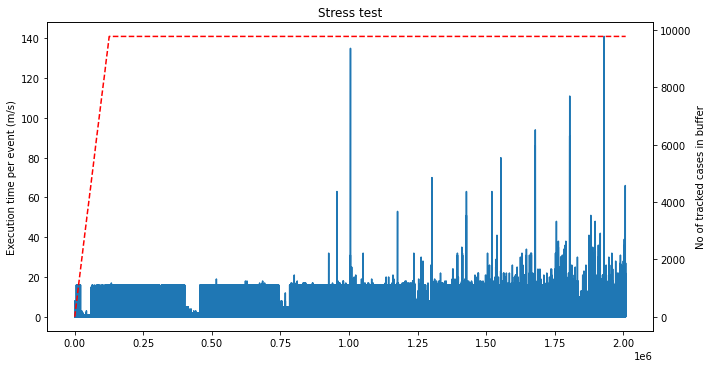

In [110]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(stress_test_time.ExecutionTime, linestyle='solid')
ax1.set_ylabel('Execution time per event (m/s)')
ax2 = ax1.twinx()
ax2.plot(stress_test_time['Total cases'], color='red', linestyle='--')
ax2.set_ylabel('No of tracked cases in buffer')
fig.tight_layout()
plt.xlabel('Events')
plt.title("Stress test")
plt.show()

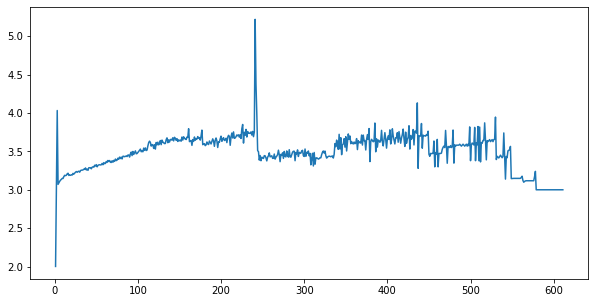

In [129]:
avg_quesize = stress_test_time.groupby('Alignment length').agg({'Total states':np.mean})
avg_quesize.head()
plt.figure(figsize=(10,5))
plt.plot(avg_quesize.index, avg_quesize['Total states']);

In [84]:
rho_time_alg = stats.spearmanr(stress_test_time['ExecutionTime'], stress_test_time['Alignment length'])
rho_time_cases = stats.spearmanr(stress_test_time['ExecutionTime'], stress_test_time['Total states'])
rho_time_states = stats.spearmanr(stress_test_time['ExecutionTime'], stress_test_time['Total cases'])

print(
    'Correlation between the measured quantities:',
    '\nExecution time - alignment length: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_alg[0], rho_time_alg[1]),
    '\nExecution time - cases size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_cases[0], rho_time_cases[1]),
    '\nExecution time - states size: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_time_states[0], rho_time_states[1])
)

Correlation between the measured quantities: 
Execution time - alignment length: spearman rho: 0.395, p-value: 0.0000000000 
Execution time - cases size: spearman rho: 0.171, p-value: 0.0000000000 
Execution time - states size: spearman rho: 0.167, p-value: 0.0000000000


### Memory usage

is missing

## Confusion Matrix

In [130]:
from sklearn import metrics

c_3po_ = C_3PO_df.copy()[['Conformance cost']]
pref_w_inf_ = pref_w_inf_df.copy()[['Conformance cost']]
pref_w_1_ = pref_w_1_df.copy()[['Conformance cost']]

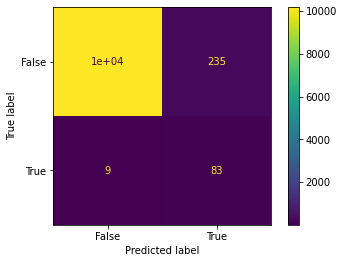

In [131]:
c_3po_['Conformance cost'] = c_3po_['Conformance cost'].apply(lambda x : True if x <= 0 else False)
pref_w_inf_['Conformance cost'] = pref_w_inf_['Conformance cost'].apply(lambda x : True if x <= 0 else False)

confusion_matrix = metrics.confusion_matrix(pref_w_inf_.values, c_3po_.values)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
pref_w_1_['Conformance cost'] = pref_w_1_['Conformance cost'].apply(lambda x : True if x <= 0 else False)

confusion_matrix = metrics.confusion_matrix(pref_w_1_.values, c_3po_.values)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

## Correlation test

### Spearman correlation with non-conforming results



#### HMMCONF

In [ ]:
hmmconf_mean_conf_compl = hmmconf_df.groupby(['model','log_type','TraceId']).agg({'finalconf': np.mean, 'completeness': np.mean, 'injected_distance': np.mean}).reset_index()

merged_df = pd.merge(hmmconf_mean_conf_compl, C_3PO_test, on=['model','log_type','TraceId'])

pred1 = merged_df['Conformance cost'] > 0
pred2 = merged_df['finalconf'] > 0

filtered_df = merged_df.loc[pred1 & pred2, :]

rho_conf_mean_finalconf = stats.spearmanr(filtered_df['Conformance cost'], filtered_df['finalconf'])
rho_conf_compl = stats.spearmanr(filtered_df['Conformance cost'], filtered_df['injected_distance'])
rho_compl_injected_distance = stats.spearmanr(filtered_df['Completeness cost'], filtered_df['injected_distance'])
rho_completeness = stats.spearmanr(filtered_df['Completeness cost'], filtered_df['completeness'])

print(
    'Conformance cost - mean final conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_mean_finalconf[0], rho_conf_mean_finalconf[1]),
    '\nConformance cost - injected distance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
    '\nCompleteness cost - injected distance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_compl_injected_distance[0], rho_compl_injected_distance[1]),
    '\nCompleteness cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_completeness[0], rho_completeness[1])
)

Conformance cost - mean final conformance: spearman rho: -0.344, p-value: 0.0000000000 
Conformance cost - injected distance: spearman rho: -0.194, p-value: 0.0000000000 
Completeness cost - injected distance: spearman rho: 0.479, p-value: 0.0000000000 
Completeness cost: spearman rho: -0.657, p-value: 0.0000000000


##### Remarks

Conformance cost - mean final conformance:
- Conformance cost and mean conformance show an inversly proportional relationship which is expected as a conformance value closer to 1 signifies that the trace is conforming to the reference model

Completeness cost - injected distance:
- Slight positive correlation which is meaningful as completeness cost and injected distance can be induced from missing tail of trace

Completeness cost:
- Similar to conformance cost and mean conformance, completeness cost and completeness share an inversly proportional relationship - correlation greater than with injected distance



#### W-1

In [ ]:
c_3po_ = C_3PO_df.copy()[['TraceId', 'Completeness cost', 'Conformance cost', 'Confidence cost', 'model', 'log_type']]
pref_w_1_ = pref_w_1_df.copy()

c_3po_ = c_3po_.rename(columns={'Conformance cost':'C_3PO_conf'})
pref_w_1_ = pref_w_1_.rename(columns={'Conformance cost':'pref_w_1_conf'})

merged_df = pd.merge(c_3po_, pref_w_1_, on=['model','log_type','TraceId'])

pred1 = merged_df['C_3PO_conf'] > 0
pred2 = merged_df['pref_w_1_conf'] > 0

filtered_df = merged_df.loc[pred1 & pred2, :]

rho_conf = stats.spearmanr(filtered_df['C_3PO_conf'], filtered_df['pref_w_1_conf'])
rho_conf_compl = stats.spearmanr(filtered_df['Completeness cost'],filtered_df['pref_w_1_conf'])

print(
    'Conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nCompleteness cost - conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
)

Conformance cost: spearman rho: 0.960, p-value: 0.0000000000 
Completeness cost - conformance cost: spearman rho: -0.469, p-value: 0.0000000000


##### Remarks

Conformance cost:
- Strong positive correlation between conformance cost in the two approaches over all traces in all logs.

Completeness cost:
- Expected positive correlation due to a higher completeness cost indicating that the trace was not observed from its begining. Thus should increase the alignment cost calculated with a conventional prefix-alignment algorithm, as it finds a path through the SPN from the starting marking. An explanation is that completeness indicates when the algorithm has to recalculated an suboptimal alignment by choosing another path in the trie. The resulting alignment costs less and taking into consideration with the strong correlation between the conformance cost of the two algorithms the corresponding alignment calculated by the SPN algorithm should be equally lower in cost.

#### W-inf

In [ ]:
pref_w_inf_ = pref_w_inf_df.copy()
pref_w_inf_ = pref_w_inf_.rename(columns={'Conformance cost':'pref_w_inf_conf'})

merged_df = pd.merge(c_3po_, pref_w_inf_, on=['model','log_type','TraceId'])

pred1 = merged_df['C_3PO_conf'] > 0
pred2 = merged_df['pref_w_inf_conf'] > 0

filtered_df = merged_df.loc[pred1 & pred2, :]

rho_conf = stats.spearmanr(filtered_df['C_3PO_conf'], filtered_df['pref_w_inf_conf'])
rho_conf_compl = stats.spearmanr(filtered_df['Completeness cost'],filtered_df['pref_w_inf_conf'])

print(
    'Conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nCompleteness cost - conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
)

Conformance cost: spearman rho: 0.973, p-value: 0.0000000000 
Completeness cost - conformance cost: spearman rho: -0.515, p-value: 0.0000000000


In [ ]:
""" completeness only """

print("Completeness logs only:")

merged_df = pd.merge(c_3po_, pref_w_inf_, on=['model','log_type','TraceId'])

pred1 = merged_df['C_3PO_conf'] > 0
pred2 = merged_df['pref_w_inf_conf'] > 0
pred3 = merged_df.log_type.isin(COMPLETENESS_LOGS)

filtered_df = merged_df.loc[pred1 & pred2 & pred3, :]

rho_conf = stats.spearmanr(filtered_df['C_3PO_conf'], filtered_df['pref_w_inf_conf'])
rho_conf_compl = stats.spearmanr(filtered_df['Completeness cost'],filtered_df['pref_w_inf_conf'])

print(
    'Conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nCompleteness cost - conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
)

Completeness logs only:
Conformance cost: spearman rho: 0.964, p-value: 0.0000000000 
Completeness cost - conformance cost: spearman rho: -0.574, p-value: 0.0000000000


##### Remarks

Conformance cost:
- Stronger positive correlation between conformance cost than W-1.

Completeness cost:
- Slightly more correlation than with W-1. Can be intrepreted together with the also slightly higher correlation between conformance cost, that completeness represents a recovery from a bad prefix-alignment.


#### BP

In [ ]:
BP_mean = BP_df.groupby(['model','log_type','TraceId']).agg({'conformance': np.mean, 'completeness': np.mean, 'confidence': np.mean}).reset_index()

merged_df = pd.merge(c_3po_, BP_mean, on=['model','log_type','TraceId'])

pred1 = merged_df['C_3PO_conf'] > 0
pred2 = merged_df['conformance'] > 0

filtered_df = merged_df.loc[pred1 & pred2, :]

rho_conformance = stats.spearmanr(filtered_df['C_3PO_conf'], filtered_df['conformance'])
rho_conformance_completeness = stats.spearmanr(filtered_df['C_3PO_conf'], filtered_df['completeness'])
rho_confidence = stats.spearmanr(filtered_df['Confidence cost'], filtered_df['confidence'])
rho_completeness = stats.spearmanr(filtered_df['Completeness cost'], filtered_df['completeness'])

print(
    'Conformance cost - mean conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conformance[0], rho_conformance[1]),
    '\nConformance cost - completeness: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conformance_completeness[0], rho_conformance_completeness[1]), 
    '\nConfidence: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_confidence[0], rho_confidence[1]),
    '\nCompleteness: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_completeness[0], rho_completeness[1])
)

Conformance cost - mean conformance: spearman rho: -0.522, p-value: 0.0000000000 
Conformance cost - completeness: spearman rho: 0.487, p-value: 0.0000000000 
Confidence: spearman rho: -0.441, p-value: 0.0000000000 
Completeness: spearman rho: -0.344, p-value: 0.0000000000


#### Remarks

Conformance cost - mean conformance:
- Higher correlation between conformance cost and conformance than with hmmconf. Same inverse relationship between the two metrics.

Conformance cost - completeness:
- Meaningfull as complete traces are longer than incomplete an thus the conformance cost will be greater.

Confidence:
- Similar relationship as with conformance cost and mean conformance. Higher confidence signals the opposite of high confidence in BP.

Completeness:
- Lesser but still expected negative correlation between the two metrics for the same reasons as with the other.

### Spearman correlation with all results

#### HMMCONF

In [ ]:
merged_df = pd.merge(hmmconf_mean_conf_compl, C_3PO_test, on=['model','log_type','TraceId'])

rho_conf_mean_finalconf = stats.spearmanr(merged_df['Conformance cost'], merged_df['finalconf'])
rho_conf_compl = stats.spearmanr(merged_df['Conformance cost'], merged_df['injected_distance'])
rho_compl_injected_distance = stats.spearmanr(merged_df['Completeness cost'], merged_df['injected_distance'])
rho_completeness = stats.spearmanr(merged_df['Completeness cost'], merged_df['completeness'])

print(
    'Conformance cost - mean final conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_mean_finalconf[0], rho_conf_mean_finalconf[1]),
    '\nConformance cost - injected distance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
    '\nCompleteness cost - injected distance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_compl_injected_distance[0], rho_compl_injected_distance[1]),
    '\nCompleteness cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_completeness[0], rho_completeness[1])
)

Conformance cost - mean final conformance: spearman rho: -0.383, p-value: 0.0000000000 
Conformance cost - injected distance: spearman rho: -0.140, p-value: 0.0000000003 
Completeness cost - injected distance: spearman rho: 0.448, p-value: 0.0000000000 
Completeness cost: spearman rho: -0.659, p-value: 0.0000000000


#### W-1

In [ ]:
merged_df = pd.merge(c_3po_, pref_w_1_, on=['model','log_type','TraceId'])

rho_conf = stats.spearmanr(merged_df['C_3PO_conf'], merged_df['pref_w_1_conf'])
rho_conf_compl = stats.spearmanr(merged_df['Completeness cost'],merged_df['pref_w_1_conf'])

print(
    'Conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nCompleteness cost - conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
)

Conformance cost: spearman rho: 0.961, p-value: 0.0000000000 
Completeness cost - conformance cost: spearman rho: -0.470, p-value: 0.0000000000


#### W-inf

In [ ]:
merged_df = pd.merge(c_3po_, pref_w_inf_, on=['model','log_type','TraceId'])

rho_conf = stats.spearmanr(merged_df['C_3PO_conf'], merged_df['pref_w_inf_conf'])
rho_conf_compl = stats.spearmanr(merged_df['Completeness cost'],merged_df['pref_w_inf_conf'])

print(
    'Conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf[0], rho_conf[1]),
    '\nCompleteness cost - conformance cost: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conf_compl[0], rho_conf_compl[1]), 
)

Conformance cost: spearman rho: 0.975, p-value: 0.0000000000 
Completeness cost - conformance cost: spearman rho: -0.515, p-value: 0.0000000000


#### BP

In [ ]:
merged_df = pd.merge(c_3po_, BP_mean, on=['model','log_type','TraceId'])

rho_conformance = stats.spearmanr(merged_df['C_3PO_conf'], merged_df['conformance'])
rho_conformance_completeness = stats.spearmanr(merged_df['C_3PO_conf'], merged_df['completeness'])
rho_confidence = stats.spearmanr(merged_df['Confidence cost'], merged_df['confidence'])
rho_completeness = stats.spearmanr(merged_df['Completeness cost'], merged_df['completeness'])

print(
    'Conformance cost - mean conformance: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conformance[0], rho_conformance[1]),
    '\nConformance cost - completeness: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_conformance_completeness[0], rho_conformance_completeness[1]), 
    '\nConfidence: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_confidence[0], rho_confidence[1]),
    '\nCompleteness: spearman rho: {:.3f}, p-value: {:.10f}'.format(rho_completeness[0], rho_completeness[1])
)

Conformance cost - mean conformance: spearman rho: -0.534, p-value: 0.0000000000 
Conformance cost - completeness: spearman rho: 0.484, p-value: 0.0000000000 
Confidence: spearman rho: -0.412, p-value: 0.0000000000 
Completeness: spearman rho: -0.360, p-value: 0.0000000000


## Cumulitative plots

### W-1

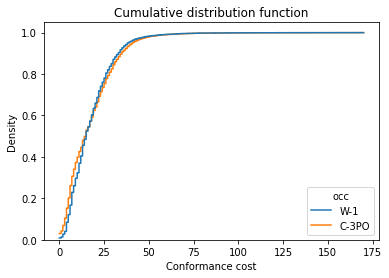

In [ ]:
pref_w_1_df['occ'] = len(pref_w_1_df) * ['W-1']
C_3PO_df['occ'] = len(C_3PO_df) * ['C-3PO']

cumu_df = pd.concat([pref_w_1_df, C_3PO_df])

sns.histplot(x='Conformance cost', data=cumu_df, hue='occ', bins=len(cumu_df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
plt.title("Cumulative distribution function");

#### Intrepretation

- lines are crossing at ~0.5 which means the median of the two distributions is the same.
- both plots exhibit an almost identical curve

### W-inf

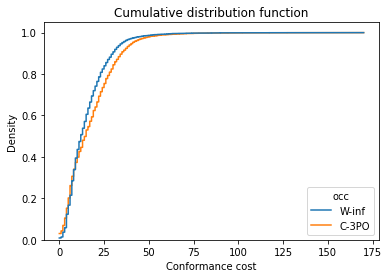

In [ ]:
pref_w_inf_df['occ'] = len(pref_w_inf_df) * ['W-inf']

cumu_df = pd.concat([pref_w_inf_df, C_3PO_df])

sns.histplot(x='Conformance cost', data=cumu_df, hue='occ', bins=len(cumu_df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
plt.title("Cumulative distribution function");

#### Intrepretation

- lines are not crossing at ~0.5 which means the median of the two distributions is not the same.
- C-3PA is more likely to estimate a lower conformance cost from ~5, thus it can be deduced that C-3PA caculates alignments with a cost lower than compared to W-inf. This is likely due to the discrepentancies within their reference models.

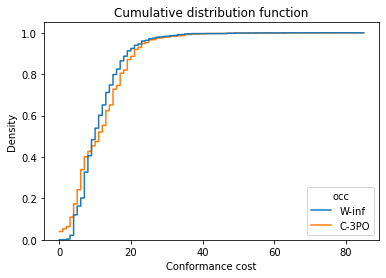

In [ ]:
"""completenes logs"""
cumu_df = cumu_df[cumu_df.log_type.isin(COMPLETENESS_LOGS)]

sns.histplot(x='Conformance cost', data=cumu_df, hue='occ', bins=len(cumu_df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
plt.title("Cumulative distribution function");

In [ ]:
# Example:

# < H > is missing as a model move in the OCC

# size = 8 \
# Trace: {C,E,G,D,B,F,A,H}

# (>>,A):1.0  \
# (C,C):0.0 \
# (E,E):0.0 \
# (G,G):0.0 \
# (>>,H):1.0                  <--- \
# (>>,F):1.0 \
# (D,D):0.0 \
# (B,B):0.0 \
# (F,>>):1.0 \
# (A,>>):1.0 \
# (H,>>):1.0

# Total cost = 6
 
# [logMove:>>, modelMove:A, cost:1] \
# [logMove:C, modelMove:C, cost:0] \
# [logMove:E, modelMove:E, cost:0] \
# [logMove:G, modelMove:G, cost:0] \
# [logMove:D, modelMove:>>, cost:1] \
# [logMove:B, modelMove:>>, cost:1] \
# [logMove:F, modelMove:>>, cost:1] \
# [logMove:A, modelMove:>>, cost:1] \
# [logMove:H, modelMove:H, cost:0]

# Total cost:5

## Real life data set evaluation

In [ ]:
import os
import pm4py
from pm4py.util import constants
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.visualization.graphs import visualizer as graphs_visualizer

RL_DIR = os.path.join('..','real-life-dataset','Hospital Billing')

log_path = os.path.join(RL_DIR,"Hospital Billing - Event Log.xes")
log = pm4py.read_xes(log_path)

parsing log, completed traces ::   0%|          | 0/100000 [00:00<?, ?it/s]

P4PY inbuilt function to plot kernel density case duration


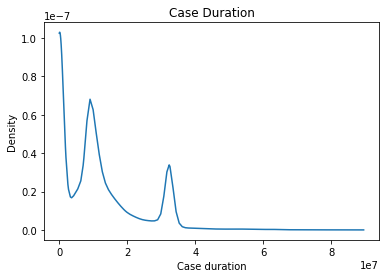

In [ ]:
""" case duration distribution """
x, y = case_statistics.get_kde_caseduration(log, parameters={constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"})

msg = "P4PY inbuilt function to plot kernel density case duration"
print(msg)

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

# gviz = graphs_visualizer.apply_semilogx(x, y, variant=graphs_visualizer.Variants.CASES)
# graphs_visualizer.view(gviz)                 

In [ ]:
result_path = os.path.join(RL_DIR, 'result.csv')
result_df = pd.read_csv(result_path)
result_df = result_df.rename(columns={
    ' Activity':'Activity',
    ' Conformance cost':'Conformance cost',
    ' Completeness cost':'Completeness cost',
    ' Confidence cost':'Confidence cost',
    ' total cost':'total cost',
    ' ExecutionTime_TRIE_STREAMING_C_3PO': 'ExecutionTime'
})

In [ ]:
""" removing noise categorized by high number of consecutive repeating activities """

t_ = result_df.groupby('TraceId')['Activity'].value_counts().groupby(level=0).head(1)
t_ = t_[t_ < 5]
idxs = t_.index.to_flat_index()
idxs = list(list(zip(*idxs))[0])
result_df = result_df.loc[result_df.TraceId.isin(idxs)]

""" removing short cases < 10 """
t_ = result_df.groupby('TraceId').agg(np.size)
t_ = t_[t_ > 10].dropna()
result_df = result_df.loc[result_df.TraceId.isin(t_.index.values)]

In [ ]:
msg = "removed noise categorized by high number of consecutive repeating activities with threshold 5\n\
removing short cases < 10"

print(msg)
print(90*"_")
result_df.info()

removed noise categorized by high number of consecutive repeating activities with threshold 5
removing short cases < 10
__________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20560 entries, 413 to 445521
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TraceId            20560 non-null  int64  
 1   Activity           20560 non-null  object 
 2   Conformance cost   20560 non-null  int64  
 3   Completeness cost  20560 non-null  int64  
 4   Confidence cost    20560 non-null  float64
 5   total cost         20560 non-null  float64
 6   ExecutionTime      20560 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.3+ MB


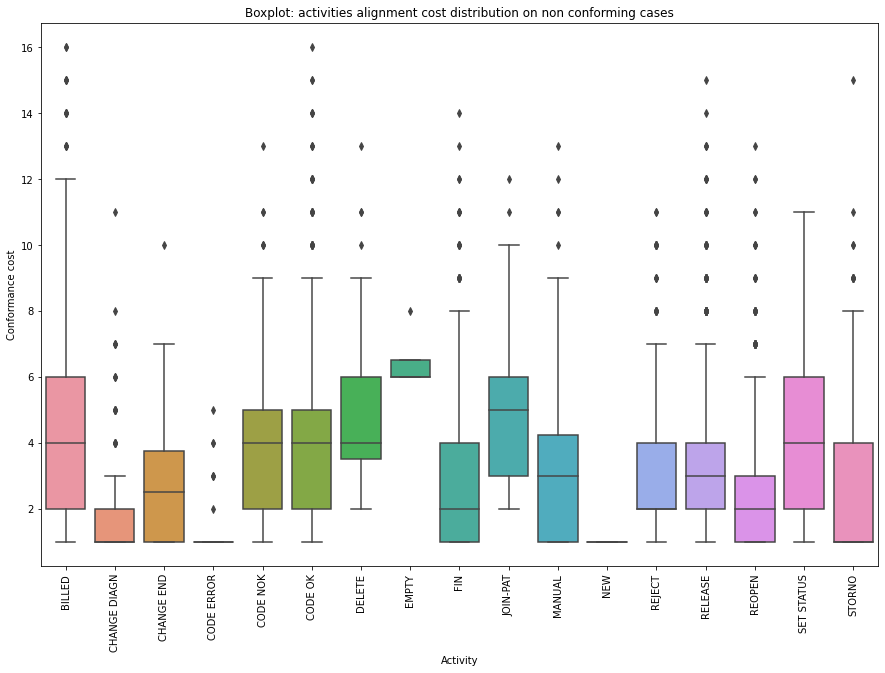

In [ ]:
""" non conforming cases """

result_ = result_df[result_df['Conformance cost'] > 0]

plt.figure(figsize=(15,10))
sns.boxplot(x='Activity', y='Conformance cost', data=result_.sort_values('Activity'));
plt.xticks(rotation=90)
plt.title("Boxplot: activities alignment cost distribution on non conforming cases");

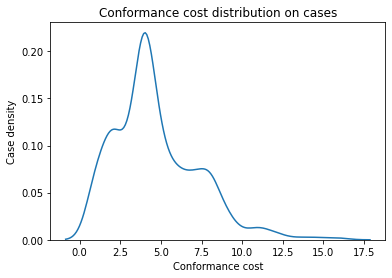

In [ ]:
result__ = result_.groupby('TraceId')['Conformance cost'].agg({np.max})

sns.kdeplot(x=[val for li in result__.values for val in li], data=result__.index, common_norm=False);
plt.ylabel("Case density")
plt.xlabel("Conformance cost")
plt.title("Conformance cost distribution on cases");